Importación de Librerias

In [5]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [1]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 kB 356.3 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181102 sha256=0e811bb775668be96eb30a4a78971294b42582c3c474fed597f817cf559aaa17
  Stored in directory: /root/.cache/pip/wheels/a4/97/94/6574311546af4d192630d77eacb23eb1b2b9e5b1a87ebea4c7
Successfully built pyod


In [2]:
from shutil import copyfile
copyfile(src = "../input/functions/libraries.py", 
         dst = "../working/libraries.py")

copyfile(src = "../input/functions/models.py", 
         dst = "../working/models.py")

# import all our functions
from libraries import timeSeq, faultData, scaling, encoding, predicted, modelMetrics
from models import KNNModel, LOFModel, OneClassSVMModel, AutoEncoderModel

## **Carga de Datos**

In [6]:
dataTrain = pd.read_csv('/kaggle/input/dataset/08_M01_DC_train.csv')
dataFault = pd.read_csv('/kaggle/input/dataset/08_M01_train_fault_data.csv')

Feature Selection

In [7]:
features = ['recipe_step','ETCHSUPPRESSORCURRENT','FLOWCOOLFLOWRATE','FLOWCOOLPRESSURE','FIXTURETILTANGLE', 
            'ROTATIONSPEED', 'ACTUALROTATIONANGLE','FIXTURESHUTTERPOSITION', 'ETCHSOURCEUSAGE', 'ETCHAUXSOURCETIMER', 
            'ACTUALSTEPDURATION']

PRIMER DATASET (DATASET ORIGINAL)

In [8]:
data = dataTrain.copy()

In [9]:
%%time
# Completamos el dataset con los eventos de falla (fault-type y fault)
datasetTrain = faultData(data, dataFault)

CPU times: user 24.3 s, sys: 7.47 s, total: 31.8 s
Wall time: 31.3 s


In [10]:
datasetTrain['fault'] = encoding(datasetTrain)

0 ['Fault']
1 ['No Fault']


SEGUNDO DATASET (DATASET ORIGINAL + SECUENCIA DE TIEMPO)

In [11]:
data = dataTrain.copy()

In [12]:
%%time
# Completamos la secuencia de datos
dataSeq = timeSeq(data, 20000)

CPU times: user 11min 58s, sys: 8.89 s, total: 12min 7s
Wall time: 12min 7s


In [13]:
%%time
# Completamos la secuencia de datos faltante
dataFilled = dataSeq.fillna(method = 'ffill')

CPU times: user 779 ms, sys: 280 ms, total: 1.06 s
Wall time: 1.06 s


In [14]:
%%time
# Incluir datos de falla
datasetFilled = faultData(dataFilled, dataFault)

CPU times: user 39.3 s, sys: 13.9 s, total: 53.2 s
Wall time: 52.4 s


In [15]:
datasetFilled['fault'] = encoding(datasetFilled)

0 ['Fault']
1 ['No Fault']


TERCER DATASET (DATASET ORIGINAL + PCA)

In [16]:
data = dataTrain.copy()

In [17]:
%%time
# Aplicamos PCA
X = data[features]
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

CPU times: user 16.6 s, sys: 7.81 s, total: 24.4 s
Wall time: 9.84 s


In [18]:
pca.explained_variance_ratio_

array([0.93902654, 0.03940789])

In [19]:
datasetPca = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

In [20]:
datasetPca[['time', 'fault']] = datasetTrain[['time', 'fault']]
datasetPca = datasetPca[['time', 'PC1', 'PC2', 'fault']]

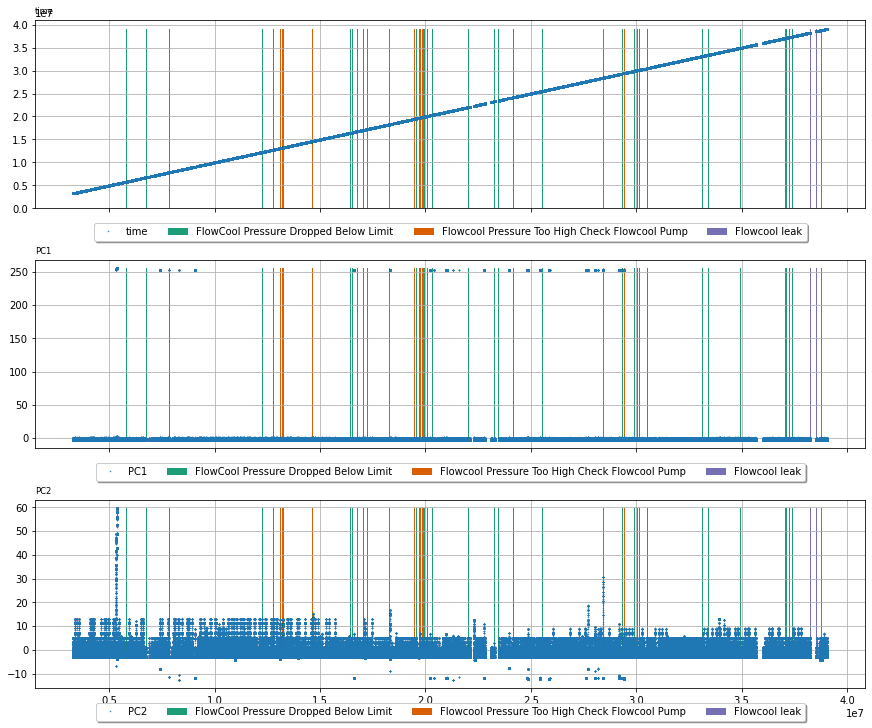

CPU times: user 6.86 s, sys: 453 ms, total: 7.31 s
Wall time: 6.85 s


In [22]:
%%time
import matplotlib.pyplot as plt
dataPlot = datasetPca.drop('fault', axis = 1)
faults = dataFault['fault_name'].unique()
fig, axs = plt.subplots(dataPlot.shape[1], 1, figsize=(12, 10), constrained_layout=True, sharex=True)
for nn, ax in enumerate(axs.flat):
    column = dataPlot.columns[nn]
    line, = ax.plot('time', column, 'o', markersize=0.5, data=dataPlot, lw=2.5)
    ax.set_title(column, fontsize='small', loc='left')
    ax.grid()
    mx = np.max(dataPlot[column])
    for idx, x in enumerate(faults):
        ln = len(dataFault['fault_name'][dataFault['fault_name'] == x])
        values = pd.DataFrame(data = [mx for i in range(ln)])[0]
        ax.bar(dataFault['time'][dataFault['fault_name'] == x],
                values, 25000, color = plt.get_cmap("Dark2").colors[idx], label = x)
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.show()

CPU times: user 2.62 s, sys: 484 ms, total: 3.1 s
Wall time: 2.84 s


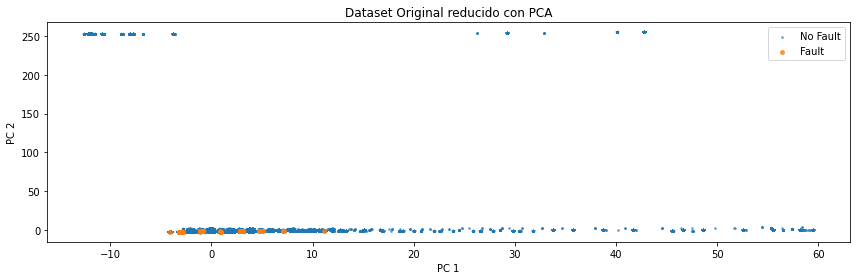

In [25]:
%%time
# Generamos el scatter plot con los PC
markers = ['x','o']
plt.figure(figsize=(12,4))
scatter = plt.scatter(datasetPca['PC2'][datasetPca['fault'] == 1], datasetPca['PC1'][datasetPca['fault'] == 1], 
                      marker = '*', s = 5, alpha = 0.5, label = 'No Fault')
scatter = plt.scatter(datasetPca['PC2'][datasetPca['fault'] == 0], datasetPca['PC1'][datasetPca['fault'] == 0], 
                      marker = 'o', s = 15, alpha = 0.8, label = 'Fault')
plt.legend()
plt.title('Dataset Original reducido con PCA')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.tight_layout()

## **DATASETS BASE**

In [21]:
datasetTrain.shape

(3716092, 26)

In [22]:
datasetFilled.shape

(5500842, 27)

In [23]:
datasetPca.shape

(3716092, 4)

## **ENTRENAMIENTO DE MODELOS**

Entrenamiento de Modelos - Dataset Original

In [29]:
data = datasetTrain.copy()
X = scaling(data[features])

KNN con Dataset Original

Entrenamiento del modelo
El tiempo transcurrido es: 11.389707 [segundos]
Predicción del modelo
El tiempo transcurrido es: 12.757395 [minutos]
Resultados:
Real
[[      0     109]
 [      1 3715983]]
Predicted
[[      0     109]
 [      1 3715983]]
Plot de Resultados
La duración del modelo ha sido: 12.765832 [minutos]


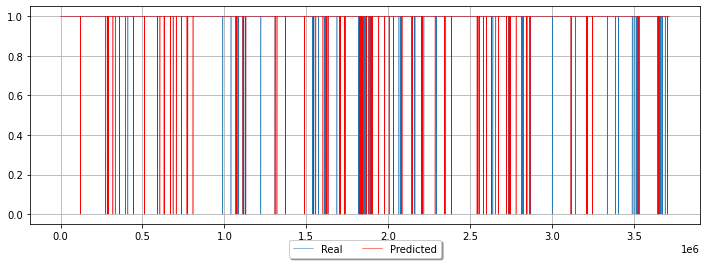

In [27]:
KNNTrain = KNNModel(X, data['fault'])

LOF con Dataset Original

Entrenamiento del modelo
El tiempo transcurrido es: 0.006413 [segundos]
Predicción del modelo
El tiempo transcurrido es: 14.250620 [minutos]
Resultados:
Real
[[      0     109]
 [      1 3715983]]
Predicted
[[      0     109]
 [      1 3715983]]
Plot de Resultados
La duración del modelo ha sido: 14.278091 [minutos]


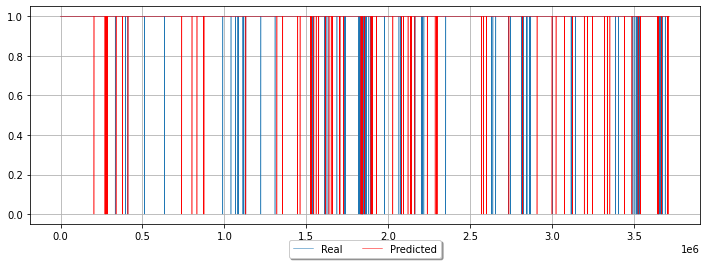

In [35]:
LOFTrain = LOFModel(X, data['fault'])

OC-SVM con Dataset Original

Entrenamiento del modelo
El tiempo transcurrido es: 2.040476 [minutos]
Predicción del modelo
El tiempo transcurrido es: 2.539351 [minutos]
Resultados:
Real
[[      0     109]
 [      1 3715983]]
Predicted
[[      0     112]
 [      1 3715980]]
Plot de Resultados
La duración del modelo ha sido: 2.565950 [minutos]


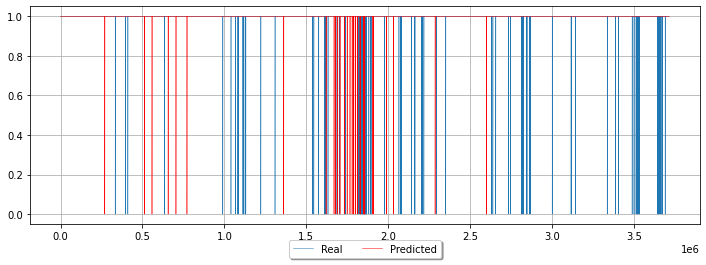

In [42]:
OCSVMTrain = OneClassSVMModel(X, data['fault'])

Entrenamiento del modelo


2023-01-22 15:58:04.057852: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 11)                132       
_________________________________________________________________
dropout (Dropout)            (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                132       
_________________________________________________________________
dropout_1 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 24        
_________________________________________________________________
dropout_2 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6

2023-01-22 15:58:04.694275: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
104516/104516 [==============================] - 210s 2ms/step - loss: 0.9936 - val_loss: 0.9786
Epoch 2/20
104516/104516 [==============================] - 214s 2ms/step - loss: 0.9919 - val_loss: 1.0006
Epoch 3/20
104516/104516 [==============================] - 222s 2ms/step - loss: 0.9999 - val_loss: 1.0006
Epoch 4/20
104516/104516 [==============================] - 224s 2ms/step - loss: 0.9999 - val_loss: 1.0006
Epoch 5/20
104516/104516 [==============================] - 229s 2ms/step - loss: 0.9999 - val_loss: 1.0006
Epoch 6/20
104516/104516 [==============================] - 251s 2ms/step - loss: 0.9999 - val_loss: 1.0006
Epoch 7/20
104516/104516 [==============================] - 253s 2ms/step - loss: 0.9999 - val_loss: 1.0006
Epoch 8/20
104516/104516 [==============================] - 251s 2ms/step - loss: 0.9999 - val_loss: 1.0006
Epoch 9/20
104516/104516 [==============================] - 252s 2ms/step - loss: 0.9999 - val_loss: 1.0006
Epoch 10/20
104516/104516 [=

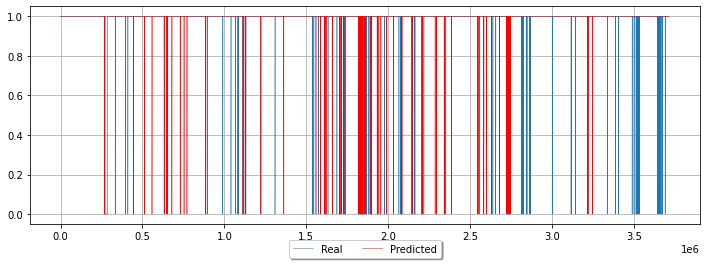

In [30]:
ATCRTrain = AutoEncoderModel(X, data['fault'],20)

Entrenamiento de Modelos - Dataset Original + Secuencia Completa

In [22]:
data = datasetFilled.copy()
X = scaling(data[features])

KNN con Dataset Original + Secuencia Completa

Entrenamiento del modelo
El tiempo transcurrido es: 17.126921 [segundos]
Predicción del modelo
El tiempo transcurrido es: 31.570685 [minutos]
Resultados:
Real
[[      0     116]
 [      1 5500726]]
Predicted
[[      0     122]
 [      1 5500720]]
Plot de Resultados
La duración del modelo ha sido: 31.584018 [minutos]


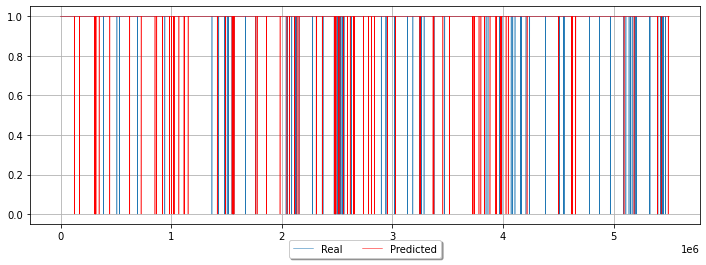

In [52]:
KNNFilled = KNNModel(X, data['fault'])

LOF con Dataset Original + Secuencia Completa

Entrenamiento del modelo
El tiempo transcurrido es: 0.010590 [segundos]
Predicción del modelo
El tiempo transcurrido es: 32.733643 [minutos]
Resultados:
Real
[[      0     116]
 [      1 5500726]]
Predicted
[[      0     115]
 [      1 5500727]]
Plot de Resultados
La duración del modelo ha sido: 32.774535 [minutos]


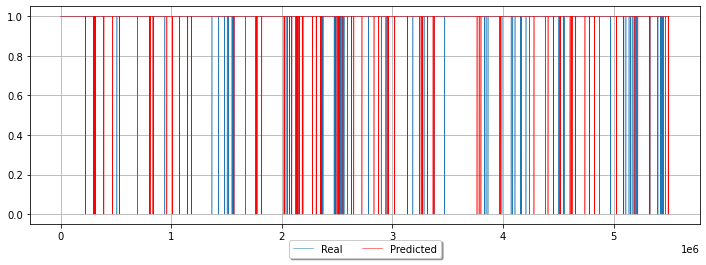

In [68]:
LOFFilled = LOFModel(X, data['fault'])

OC-SVM con Dataset Original + Secuencia Completa

Entrenamiento del modelo
El tiempo transcurrido es: 5.125485 [minutos]
Predicción del modelo
El tiempo transcurrido es: 5.914151 [minutos]
Resultados:
Real
[[      0     116]
 [      1 5500726]]
Predicted
[[      0     155]
 [      1 5500687]]
Plot de Resultados
La duración del modelo ha sido: 5.955366 [minutos]


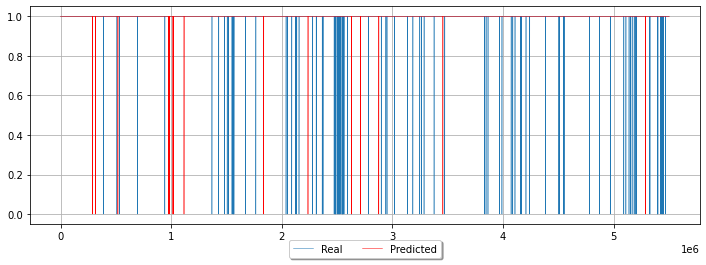

In [67]:
OCSVMFilled = OneClassSVMModel(X, data['fault'])

Autoencoder con Dataset Original + Secuencia Completa

Entrenamiento del modelo


2023-01-23 00:50:18.669004: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 11)                132       
_________________________________________________________________
dropout (Dropout)            (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                132       
_________________________________________________________________
dropout_1 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 24        
_________________________________________________________________
dropout_2 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6

2023-01-23 00:50:19.559499: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/6
154712/154712 [==============================] - 333s 2ms/step - loss: 1.0034 - val_loss: 1.0055
Epoch 2/6
154712/154712 [==============================] - 342s 2ms/step - loss: 0.9994 - val_loss: 1.0055
Epoch 3/6
154712/154712 [==============================] - 357s 2ms/step - loss: 0.9994 - val_loss: 1.0055
Epoch 4/6
154712/154712 [==============================] - 378s 2ms/step - loss: 0.9994 - val_loss: 1.0055
Epoch 5/6
154712/154712 [==============================] - 347s 2ms/step - loss: 0.9994 - val_loss: 1.0055
Epoch 6/6
154712/154712 [==============================] - 345s 2ms/step - loss: 0.9994 - val_loss: 1.0055
El tiempo transcurrido es: 38.183740 [minutos]
Predicción del modelo
El tiempo transcurrido es: 41.106781 [minutos]
Resultados:
Real
[[      0     116]
 [      1 5500726]]
Predicted
[[      0   82513]
 [      1 5418329]]
Plot de Resultados
La duración del modelo ha sido: 41.119945 [minutos]


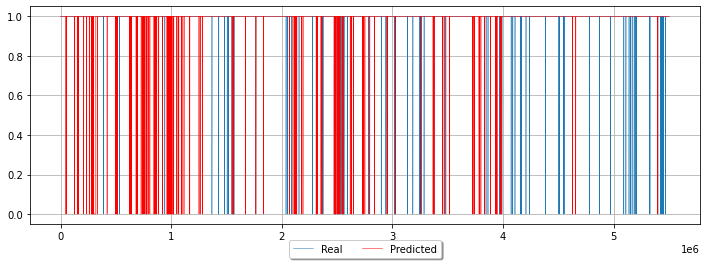

In [23]:
ATCRFilled = AutoEncoderModel(X, data['fault'],6)

Dataset Original + PCA

In [24]:
data = datasetPca.copy()
X = scaling(data[['PC1','PC2']])

KNN con Dataset Original + PCA

Entrenamiento del modelo
El tiempo transcurrido es: 2.056288 [segundos]
Predicción del modelo
El tiempo transcurrido es: 0.268272 [minutos]
Resultados:
Real
[[      0     109]
 [      1 3715983]]
Predicted
[[      0     185]
 [      1 3715907]]
Plot de Resultados
La duración del modelo ha sido: 0.272909 [minutos]


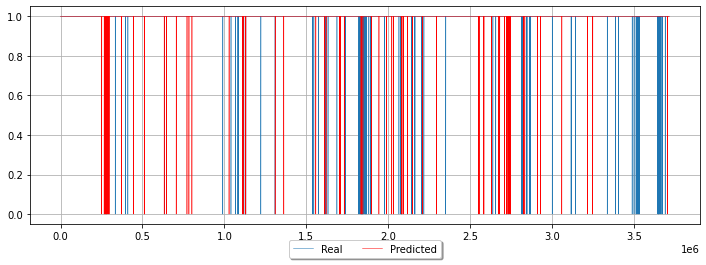

In [34]:
KNNPCA = KNNModel(X, data['fault'])

LOF con Dataset Original + PCA

Entrenamiento del modelo
El tiempo transcurrido es: 0.005913 [segundos]
Predicción del modelo
El tiempo transcurrido es: 0.247222 [minutos]
Resultados:
Real
[[      0     109]
 [      1 3715983]]
Predicted
[[      0     109]
 [      1 3715983]]
Plot de Resultados
La duración del modelo ha sido: 0.266537 [minutos]


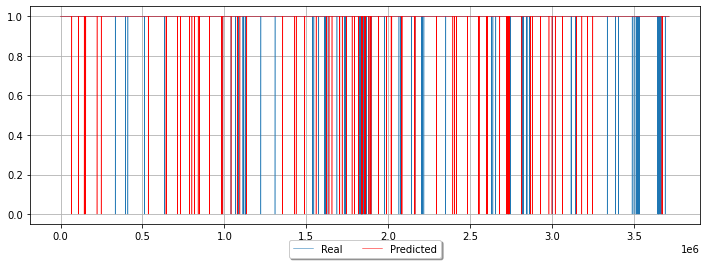

In [26]:
LOFPCA = LOFModel(X, data['fault'])

OneClassSVM con Dataset Original + PCA

Entrenamiento del modelo
El tiempo transcurrido es: 1.252896 [minutos]
Predicción del modelo
El tiempo transcurrido es: 1.620225 [minutos]
Resultados:
Real
[[      0     109]
 [      1 3715983]]
Predicted
[[      0     226]
 [      1 3715866]]
Plot de Resultados
La duración del modelo ha sido: 1.639426 [minutos]


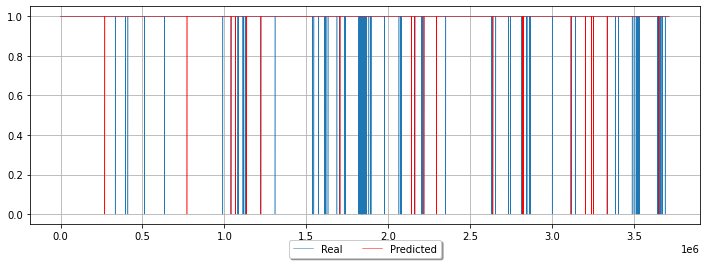

In [38]:
OCSVMPCA = OneClassSVMModel(X, data['fault'])

Autoencoder con Dataset Original + PCA

Entrenamiento del modelo


2023-01-23 06:58:31.052070: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dropout (Dropout)            (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6

2023-01-23 06:58:31.432860: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/6
104516/104516 [==============================] - 246s 2ms/step - loss: 1.0034 - val_loss: 0.9998
Epoch 2/6
104516/104516 [==============================] - 253s 2ms/step - loss: 1.0000 - val_loss: 0.9998
Epoch 3/6
104516/104516 [==============================] - 272s 3ms/step - loss: 1.0000 - val_loss: 0.9998
Epoch 4/6
104516/104516 [==============================] - 251s 2ms/step - loss: 1.0000 - val_loss: 0.9998
Epoch 5/6
104516/104516 [==============================] - 259s 2ms/step - loss: 1.0000 - val_loss: 0.9998
Epoch 6/6
104516/104516 [==============================] - 249s 2ms/step - loss: 1.0000 - val_loss: 0.9998
El tiempo transcurrido es: 27.889637 [minutos]
Predicción del modelo
El tiempo transcurrido es: 30.057651 [minutos]
Resultados:
Real
[[      0     109]
 [      1 3715983]]
Predicted
[[      0   55742]
 [      1 3660350]]
Plot de Resultados
La duración del modelo ha sido: 30.066917 [minutos]


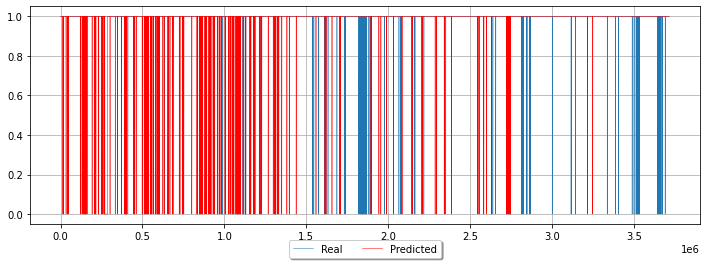

In [25]:
ATCRPCA = AutoEncoderModel(X, data['fault'],6)

## **RESULTADOS**

KNN con Dataset Original

In [28]:
KNNTrainPred = predicted(datasetTrain.time, datasetTrain.fault, KNNTrain[0], datasetTrain['fault_type'], 86400)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    NO         nan        nan       
9157996    NO         nan        nan       
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   NO         nan        nan       
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   YES        6.7        Flowcool Pressure Too High Check Flowcool Pump
13220880   YES        20.39      Flowcool Pressure Too High Check Flowcool Pump
13224756   YES        21.46      Flowcool Pressure Too High Check Flowcool Pump
13230776   YES        0.69       Flowcool Pressure Too High Check Flowcool Pump
13255688   YES        5.95       Flowcool Pressure Too High Check Flowcool Pump
13275884   YES        5.37  

El f1-score del Modelo es: 0.99998008603907551084


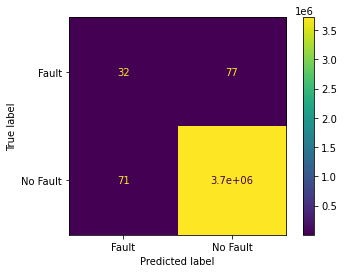

In [30]:
modelMetrics(datasetTrain.fault, KNNTrainPred)

In [31]:
KNNTrainPred = predicted(datasetTrain.time, datasetTrain.fault, KNNTrain[0], datasetTrain['fault_type'], 86400*2)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    NO         nan        nan       
9157996    YES        24.45      FlowCool Pressure Dropped Below Limit
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   YES        32.32      FlowCool Pressure Dropped Below Limit
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   YES        6.7        Flowcool Pressure Too High Check Flowcool Pump
13220880   YES        20.39      Flowcool Pressure Too High Check Flowcool Pump
13224756   YES        21.46      Flowcool Pressure Too High Check Flowcool Pump
13230776   YES        0.69       Flowcool Pressure Too High Check Flowcool Pump
13255688   YES        5.95       Flowcool Pressure Too

El f1-score del Modelo es: 0.99998506450720081595


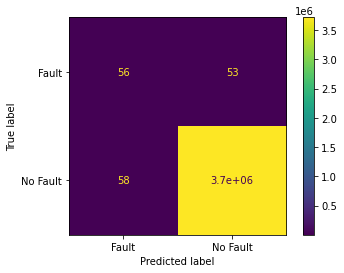

In [32]:
modelMetrics(datasetTrain.fault, KNNTrainPred)

In [33]:
KNNTrainPred = predicted(datasetTrain.time, datasetTrain.fault, KNNTrain[0], datasetTrain['fault_type'], 86400*3)

timestamp  Predicted  hours      Type      
5817194    YES        69.44      FlowCool Pressure Dropped Below Limit
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    NO         nan        nan       
9157996    YES        24.45      FlowCool Pressure Dropped Below Limit
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   YES        32.32      FlowCool Pressure Dropped Below Limit
12869030   YES        51.28      FlowCool Pressure Dropped Below Limit
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   YES        6.7        Flowcool Pressure Too High Check Flowcool Pump
13220880   YES        20.39      Flowcool Pressure Too High Check Flowcool Pump
13224756   YES        21.46      Flowcool Pressure Too High Check Flowcool Pump
13230776   YES        0.69       Flowcool Pressure Too High Check Flowcool Pump


El f1-score del Modelo es: 0.99998641004343524763


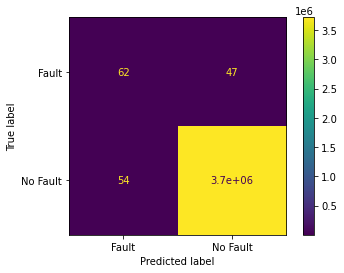

In [34]:
modelMetrics(datasetTrain.fault, KNNTrainPred)

LOF con Dataset Original

In [36]:
LOFTrainPred = predicted(datasetTrain.time, datasetTrain.fault, LOFTrain[0][0], datasetTrain['fault_type'], 86400)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    NO         nan        nan       
9157996    NO         nan        nan       
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   NO         nan        nan       
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   YES        5.37       Flowcool Pressure Too High Check Flowcool Pump
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454938   YES        15.97      FlowCoo

El f1-score del Modelo es: 0.99997914413728916649


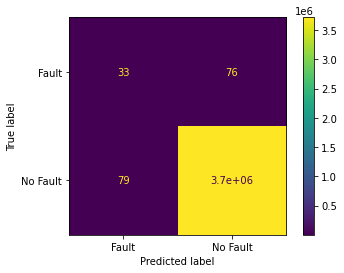

In [37]:
modelMetrics(datasetTrain.fault, LOFTrainPred)

In [38]:
LOFTrainPred = predicted(datasetTrain.time, datasetTrain.fault, LOFTrain[0][0], datasetTrain['fault_type'], 86400*2)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    NO         nan        nan       
9157996    NO         nan        nan       
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   NO         nan        nan       
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   YES        5.37       Flowcool Pressure Too High Check Flowcool Pump
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454938   YES        15.97      FlowCoo

El f1-score del Modelo es: 0.99998089332068162971


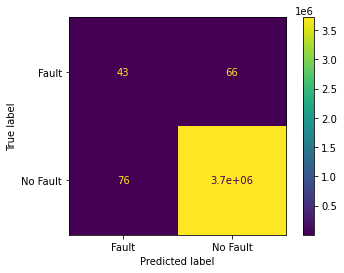

In [39]:
modelMetrics(datasetTrain.fault, LOFTrainPred)

In [40]:
LOFTrainPred = predicted(datasetTrain.time, datasetTrain.fault, LOFTrain[0][0], datasetTrain['fault_type'], 86400*3)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    YES        71.04      FlowCool Pressure Dropped Below Limit
6761130    NO         nan        nan       
7858638    NO         nan        nan       
9157996    NO         nan        nan       
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   NO         nan        nan       
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   YES        5.37       Flowcool Pressure Too High Check Flowcool Pump
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454938   YE

El f1-score del Modelo es: 0.99998196975331932190


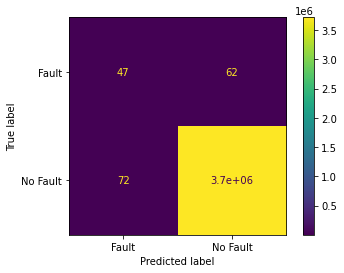

In [41]:
modelMetrics(datasetTrain.fault, LOFTrainPred)

OneClassSVM con Dataset Original

In [43]:
OCSVMTrainPred = predicted(datasetTrain.time, datasetTrain.fault, OCSVMTrain[0][0], datasetTrain['fault_type'], 86400)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    YES        0.27       FlowCool Pressure Dropped Below Limit
9157996    NO         nan        nan       
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   NO         nan        nan       
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   NO         nan        nan       
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454938   NO         nan        nan       
16546

El f1-score del Modelo es: 0.99997860600783661233


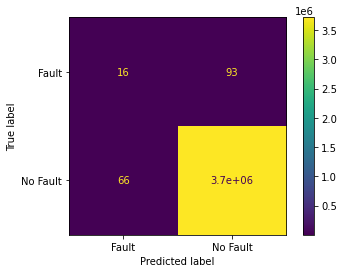

In [46]:
modelMetrics(datasetTrain.fault, OCSVMTrainPred)

In [47]:
OCSVMTrainPred = predicted(datasetTrain.time, datasetTrain.fault, OCSVMTrain[0][0], datasetTrain['fault_type'], 86400*2)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    YES        0.27       FlowCool Pressure Dropped Below Limit
9157996    NO         nan        nan       
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   NO         nan        nan       
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   NO         nan        nan       
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454938   NO         nan        nan       
16546

El f1-score del Modelo es: 0.99998008608194732805


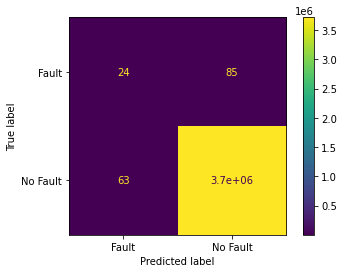

In [48]:
modelMetrics(datasetTrain.fault, OCSVMTrainPred)

In [49]:
OCSVMTrainPred = predicted(datasetTrain.time, datasetTrain.fault, OCSVMTrain[0][0], datasetTrain['fault_type'], 86400*3)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    YES        0.27       FlowCool Pressure Dropped Below Limit
9157996    NO         nan        nan       
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   NO         nan        nan       
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   NO         nan        nan       
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454938   NO         nan        nan       
16546

El f1-score del Modelo es: 0.99998223893795301631


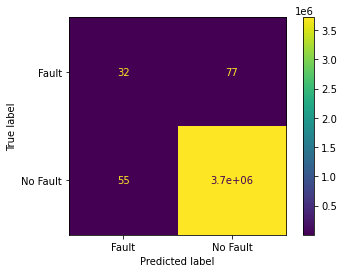

In [50]:
modelMetrics(datasetTrain.fault, OCSVMTrainPred)

Autoencoder con Dataset Original

In [31]:
ATCRTrainPred = predicted(datasetTrain.time, datasetTrain.fault, ATCRTrain[0][0], datasetTrain['fault_type'], 86400)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    YES        0.27       FlowCool Pressure Dropped Below Limit
9157996    NO         nan        nan       
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   NO         nan        nan       
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   YES        7.21       Flowcool Pressure Too High Check Flowcool Pump
13220880   NO         nan        nan       
13224756   YES        0.0        Flowcool Pressure Too High Check Flowcool Pump
13230776   YES        0.68       Flowcool Pressure Too High Check Flowcool Pump
13255688   YES        5.8        Flowcool Pressure Too High Check Flowcool Pump
13275884   YES        5.37       Flow

El f1-score del Modelo es: 0.99411337976509828174


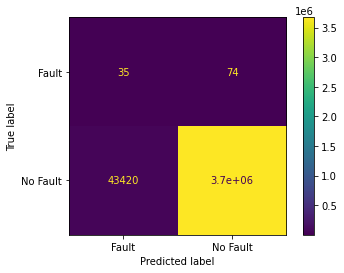

In [32]:
modelMetrics(datasetTrain.fault, ATCRTrainPred)

In [33]:
ATCRTrainPred = predicted(datasetTrain.time, datasetTrain.fault, ATCRTrain[0][0], datasetTrain['fault_type'], 86400*2)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    YES        0.27       FlowCool Pressure Dropped Below Limit
9157996    YES        24.7       FlowCool Pressure Dropped Below Limit
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   NO         nan        nan       
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   YES        7.21       Flowcool Pressure Too High Check Flowcool Pump
13220880   YES        27.73      Flowcool Pressure Too High Check Flowcool Pump
13224756   YES        0.0        Flowcool Pressure Too High Check Flowcool Pump
13230776   YES        0.68       Flowcool Pressure Too High Check Flowcool Pump
13255688   YES        5.8        Flowcool Pressure Too

El f1-score del Modelo es: 0.99474955209288873359


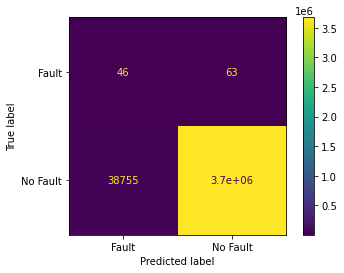

In [34]:
modelMetrics(datasetTrain.fault, ATCRTrainPred)

In [35]:
ATCRTrainPred = predicted(datasetTrain.time, datasetTrain.fault, ATCRTrain[0][0], datasetTrain['fault_type'], 86400*3)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    YES        0.27       FlowCool Pressure Dropped Below Limit
9157996    YES        24.7       FlowCool Pressure Dropped Below Limit
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   NO         nan        nan       
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   YES        7.21       Flowcool Pressure Too High Check Flowcool Pump
13220880   YES        27.73      Flowcool Pressure Too High Check Flowcool Pump
13224756   YES        0.0        Flowcool Pressure Too High Check Flowcool Pump
13230776   YES        0.68       Flowcool Pressure Too High Check Flowcool Pump
13255688   YES        5.8        Flowcool Pressure Too

El f1-score del Modelo es: 0.99550916999995264778


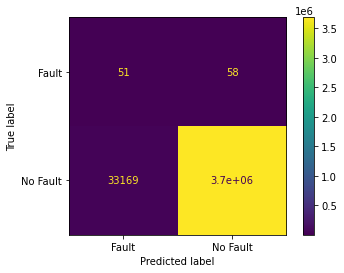

In [36]:
modelMetrics(datasetTrain.fault, ATCRTrainPred)

KNN con Dataset Original + Secuencia Completa

In [53]:
KNNFilledPred = predicted(datasetFilled.time, datasetFilled.fault, KNNFilled[0], datasetFilled['fault_type'], 86400)

timestamp  Predicted  hours      Type      
5816878    NO         nan        nan       
6562544    NO         nan        nan       
6760814    NO         nan        nan       
7858638    NO         nan        nan       
9157658    NO         nan        nan       
11779286   NO         nan        nan       
12276396   NO         nan        nan       
12631192   NO         nan        nan       
12800366   NO         nan        nan       
12868650   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   YES        6.7        Flowcool Pressure Too High Check Flowcool Pump
13220880   YES        20.39      Flowcool Pressure Too High Check Flowcool Pump
13224756   YES        21.46      Flowcool Pressure Too High Check Flowcool Pump
13230776   YES        0.69       Flowcool Pressure Too High Check Flowcool Pump
13255688   YES        5.95       Flowcool Pressure Too High Check Flowcool Pump
13275884   YES        5.37  

El f1-score del Modelo es: 0.99998572915777572678


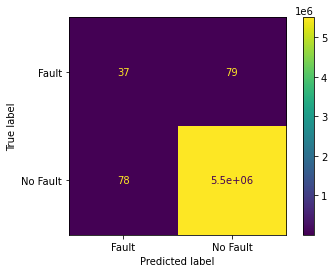

In [55]:
modelMetrics(datasetFilled.fault, KNNFilledPred)

In [56]:
KNNFilledPred = predicted(datasetFilled.time, datasetFilled.fault, KNNFilled[0], datasetFilled['fault_type'], 86400*2)

timestamp  Predicted  hours      Type      
5816878    NO         nan        nan       
6562544    NO         nan        nan       
6760814    NO         nan        nan       
7858638    NO         nan        nan       
9157658    YES        24.36      FlowCool Pressure Dropped Below Limit
11779286   NO         nan        nan       
12276396   YES        24.87      FlowCool Pressure Dropped Below Limit
12631192   NO         nan        nan       
12800366   YES        32.21      FlowCool Pressure Dropped Below Limit
12868650   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   YES        6.7        Flowcool Pressure Too High Check Flowcool Pump
13220880   YES        20.39      Flowcool Pressure Too High Check Flowcool Pump
13224756   YES        21.46      Flowcool Pressure Too High Check Flowcool Pump
13230776   YES        0.69       Flowcool Pressure Too High Check Flowcool Pump
13255688   YES        5.95 

El f1-score del Modelo es: 0.99998963772015292406


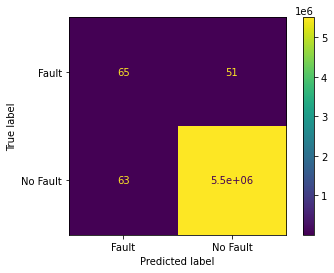

In [57]:
modelMetrics(datasetFilled.fault, KNNFilledPred)

In [58]:
KNNFilledPred = predicted(datasetFilled.time, datasetFilled.fault, KNNFilled[0], datasetFilled['fault_type'], 86400*3)

timestamp  Predicted  hours      Type      
5816878    YES        69.36      FlowCool Pressure Dropped Below Limit
6562544    NO         nan        nan       
6760814    NO         nan        nan       
7858638    NO         nan        nan       
9157658    YES        24.36      FlowCool Pressure Dropped Below Limit
11779286   NO         nan        nan       
12276396   YES        24.87      FlowCool Pressure Dropped Below Limit
12631192   NO         nan        nan       
12800366   YES        32.21      FlowCool Pressure Dropped Below Limit
12868650   YES        51.18      FlowCool Pressure Dropped Below Limit
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   YES        6.7        Flowcool Pressure Too High Check Flowcool Pump
13220880   YES        20.39      Flowcool Pressure Too High Check Flowcool Pump
13224756   YES        21.46      Flowcool Pressure Too High Check Flowcool Pump
13230776   YES        0.69       Flowcool Pressure To

El f1-score del Modelo es: 0.99999045579401035777


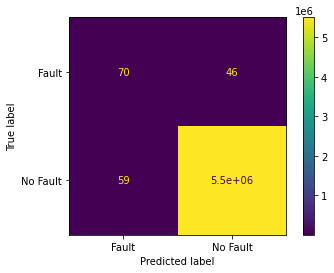

In [59]:
modelMetrics(datasetFilled.fault, KNNFilledPred)

LOF con Dataset Origina + Secuencia Completa

In [61]:
LOFFilledPred = predicted(datasetFilled.time, datasetFilled.fault, LOFFilled[0][0], datasetFilled['fault_type'], 86400)

timestamp  Predicted  hours      Type      
5816878    NO         nan        nan       
6562544    NO         nan        nan       
6760814    NO         nan        nan       
7858638    NO         nan        nan       
9157658    NO         nan        nan       
11779286   NO         nan        nan       
12276396   NO         nan        nan       
12631192   NO         nan        nan       
12800366   NO         nan        nan       
12868650   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   YES        5.37       Flowcool Pressure Too High Check Flowcool Pump
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454520   YES        15.85      FlowCoo

El f1-score del Modelo es: 0.99998482018693357620


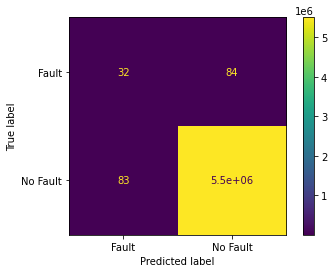

In [62]:
modelMetrics(datasetFilled.fault, LOFFilledPred)

In [69]:
LOFFilledPred = predicted(datasetFilled.time, datasetFilled.fault, LOFFilled[0][0], datasetFilled['fault_type'], 86400*2)

timestamp  Predicted  hours      Type      
5816878    NO         nan        nan       
6562544    NO         nan        nan       
6760814    NO         nan        nan       
7858638    NO         nan        nan       
9157658    NO         nan        nan       
11779286   NO         nan        nan       
12276396   NO         nan        nan       
12631192   NO         nan        nan       
12800366   NO         nan        nan       
12868650   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   YES        5.37       Flowcool Pressure Too High Check Flowcool Pump
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454520   YES        15.85      FlowCoo

El f1-score del Modelo es: 0.99998609274105609845


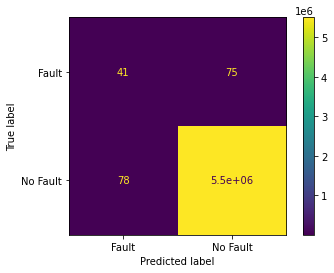

In [70]:
modelMetrics(datasetFilled.fault, LOFFilledPred)

In [71]:
LOFFilledPred = predicted(datasetFilled.time, datasetFilled.fault, LOFFilled[0][0], datasetFilled['fault_type'], 86400*3)

timestamp  Predicted  hours      Type      
5816878    NO         nan        nan       
6562544    YES        70.96      FlowCool Pressure Dropped Below Limit
6760814    NO         nan        nan       
7858638    NO         nan        nan       
9157658    NO         nan        nan       
11779286   NO         nan        nan       
12276396   NO         nan        nan       
12631192   NO         nan        nan       
12800366   NO         nan        nan       
12868650   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   YES        5.37       Flowcool Pressure Too High Check Flowcool Pump
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454520   YE

El f1-score del Modelo es: 0.99998745619439488586


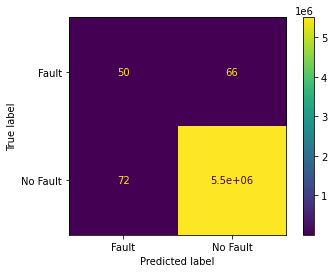

In [72]:
modelMetrics(datasetFilled.fault, LOFFilledPred)

OC-SVM con Dataset Original + Secuencia Completa

In [73]:
OSVMFilledPred = predicted(datasetFilled.time, datasetFilled.fault, OCSVMFilled[0][0], datasetFilled['fault_type'], 86400)

timestamp  Predicted  hours      Type      
5816878    NO         nan        nan       
6562544    NO         nan        nan       
6760814    NO         nan        nan       
7858638    NO         nan        nan       
9157658    NO         nan        nan       
11779286   NO         nan        nan       
12276396   NO         nan        nan       
12631192   NO         nan        nan       
12800366   NO         nan        nan       
12868650   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   NO         nan        nan       
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454520   NO         nan        nan       
16533396   NO         nan       

El f1-score del Modelo es: 0.99997636669150580246


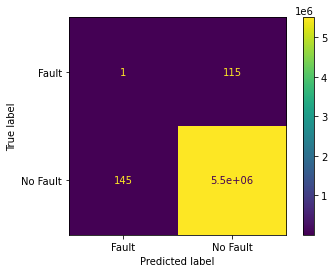

In [74]:
modelMetrics(datasetFilled.fault, OSVMFilledPred)

In [75]:
OSVMFilledPred = predicted(datasetFilled.time, datasetFilled.fault, OCSVMFilled[0][0], datasetFilled['fault_type'], 86400*2)

timestamp  Predicted  hours      Type      
5816878    NO         nan        nan       
6562544    NO         nan        nan       
6760814    YES        31.5       FlowCool Pressure Dropped Below Limit
7858638    NO         nan        nan       
9157658    NO         nan        nan       
11779286   NO         nan        nan       
12276396   NO         nan        nan       
12631192   NO         nan        nan       
12800366   NO         nan        nan       
12868650   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   NO         nan        nan       
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454520   NO         nan        nan       
16533

El f1-score del Modelo es: 0.99997754837529784222


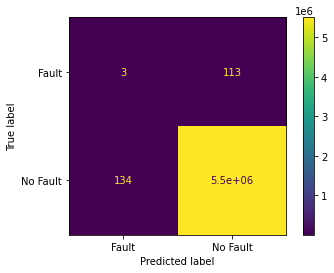

In [76]:
modelMetrics(datasetFilled.fault, OSVMFilledPred)

In [77]:
OSVMFilledPred = predicted(datasetFilled.time, datasetFilled.fault, OCSVMFilled[0][0], datasetFilled['fault_type'], 86400*3)

timestamp  Predicted  hours      Type      
5816878    NO         nan        nan       
6562544    NO         nan        nan       
6760814    YES        31.5       FlowCool Pressure Dropped Below Limit
7858638    NO         nan        nan       
9157658    NO         nan        nan       
11779286   NO         nan        nan       
12276396   NO         nan        nan       
12631192   NO         nan        nan       
12800366   NO         nan        nan       
12868650   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   NO         nan        nan       
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454520   NO         nan        nan       
16533

El f1-score del Modelo es: 0.99997773016982971495


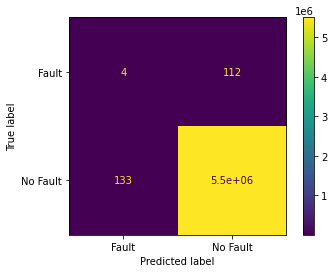

In [78]:
modelMetrics(datasetFilled.fault, OSVMFilledPred)

Autoencoder con Dataset Completo + Secuencia Completa

In [24]:
ATCRFilledPred = predicted(datasetFilled.time, datasetFilled.fault, ATCRFilled[0][0], datasetFilled['fault_type'], 86400)

timestamp  Predicted  hours      Type      
5816878    NO         nan        nan       
6562544    YES        7.42       FlowCool Pressure Dropped Below Limit
6760814    NO         nan        nan       
7858638    YES        0.27       FlowCool Pressure Dropped Below Limit
9157658    NO         nan        nan       
11779286   NO         nan        nan       
12276396   NO         nan        nan       
12631192   NO         nan        nan       
12800366   NO         nan        nan       
12868650   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   YES        7.21       Flowcool Pressure Too High Check Flowcool Pump
13220880   NO         nan        nan       
13224756   YES        0.0        Flowcool Pressure Too High Check Flowcool Pump
13230776   YES        0.68       Flowcool Pressure Too High Check Flowcool Pump
13255688   YES        5.8        Flowcool Pressure Too High Check Flowcool Pump
13275884  

El f1-score del Modelo es: 0.99417280734242552409


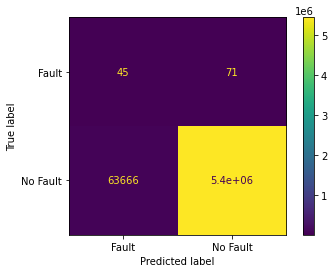

In [25]:
modelMetrics(datasetFilled.fault, ATCRFilledPred)

In [26]:
ATCRFilledPred = predicted(datasetFilled.time, datasetFilled.fault, ATCRFilled[0][0], datasetFilled['fault_type'], 86400*2)

timestamp  Predicted  hours      Type      
5816878    NO         nan        nan       
6562544    YES        7.42       FlowCool Pressure Dropped Below Limit
6760814    YES        42.07      FlowCool Pressure Dropped Below Limit
7858638    YES        0.27       FlowCool Pressure Dropped Below Limit
9157658    YES        24.35      FlowCool Pressure Dropped Below Limit
11779286   NO         nan        nan       
12276396   NO         nan        nan       
12631192   NO         nan        nan       
12800366   NO         nan        nan       
12868650   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   YES        7.21       Flowcool Pressure Too High Check Flowcool Pump
13220880   YES        27.73      Flowcool Pressure Too High Check Flowcool Pump
13224756   YES        0.0        Flowcool Pressure Too High Check Flowcool Pump
13230776   YES        0.68       Flowcool Pressure Too High Check Flowcool Pump


El f1-score del Modelo es: 0.99476070760965640272


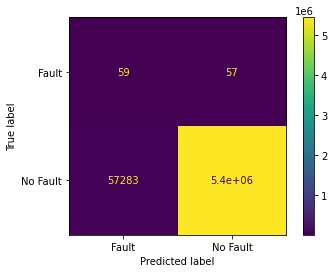

In [27]:
modelMetrics(datasetFilled.fault, ATCRFilledPred)

In [28]:
ATCRFilledPred = predicted(datasetFilled.time, datasetFilled.fault, ATCRFilled[0][0], datasetFilled['fault_type'], 86400*3)

timestamp  Predicted  hours      Type      
5816878    NO         nan        nan       
6562544    YES        7.42       FlowCool Pressure Dropped Below Limit
6760814    YES        42.07      FlowCool Pressure Dropped Below Limit
7858638    YES        0.27       FlowCool Pressure Dropped Below Limit
9157658    YES        24.35      FlowCool Pressure Dropped Below Limit
11779286   NO         nan        nan       
12276396   NO         nan        nan       
12631192   NO         nan        nan       
12800366   NO         nan        nan       
12868650   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   YES        7.21       Flowcool Pressure Too High Check Flowcool Pump
13220880   YES        27.73      Flowcool Pressure Too High Check Flowcool Pump
13224756   YES        0.0        Flowcool Pressure Too High Check Flowcool Pump
13230776   YES        0.68       Flowcool Pressure Too High Check Flowcool Pump


El f1-score del Modelo es: 0.99521167347755912225


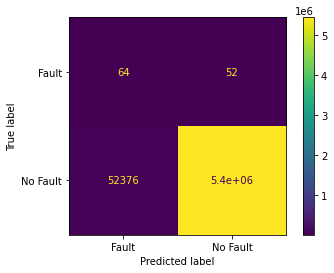

In [29]:
modelMetrics(datasetFilled.fault, ATCRFilledPred)

KNN con Dataset Original + PCA

In [81]:
KNNPCAPred = predicted(datasetPca.time, datasetPca.fault, KNNPCA[0], datasetTrain['fault_type'], 86400)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    YES        0.52       FlowCool Pressure Dropped Below Limit
9157996    NO         nan        nan       
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   NO         nan        nan       
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   YES        0.36       Flowcool Pressure Too High Check Flowcool Pump
13147004   YES        6.7        Flowcool Pressure Too High Check Flowcool Pump
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   YES        0.69       Flowcool Pressure Too High Check Flowcool Pump
13255688   YES        7.61       Flowcool Pressure Too High Check Flowcool Pump
13275884   YES        5.36       Flow

El f1-score del Modelo es: 0.99997053251777034966


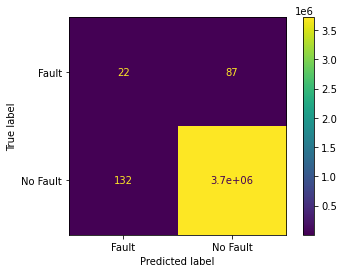

In [82]:
modelMetrics(datasetPca.fault, KNNPCAPred)

In [35]:
KNNPCAPred = predicted(datasetPca.time, datasetPca.fault, KNNPCA[0], datasetTrain['fault_type'], 86400*2)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    YES        0.52       FlowCool Pressure Dropped Below Limit
9157996    YES        24.45      FlowCool Pressure Dropped Below Limit
11779286   NO         nan        nan       
12276768   YES        34.36      FlowCool Pressure Dropped Below Limit
12631572   NO         nan        nan       
12800746   NO         nan        nan       
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   YES        0.36       Flowcool Pressure Too High Check Flowcool Pump
13147004   YES        6.7        Flowcool Pressure Too High Check Flowcool Pump
13220880   YES        27.23      Flowcool Pressure Too High Check Flowcool Pump
13224756   YES        28.3       Flowcool Pressure Too High Check Flowcool Pump
13230776   YES        0.69       Flowcool Pressure Too High Check Flowc

El f1-score del Modelo es: 0.99997430002899656554


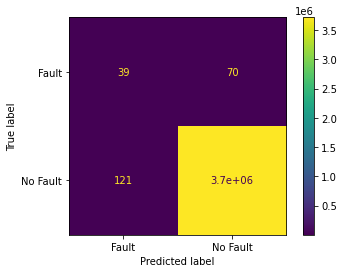

In [36]:
modelMetrics(datasetPca.fault, KNNPCAPred)

In [37]:
KNNPCAPred =predicted(datasetPca.time, datasetPca.fault, KNNPCA[0], datasetTrain['fault_type'], 86400*3)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    YES        0.52       FlowCool Pressure Dropped Below Limit
9157996    YES        24.45      FlowCool Pressure Dropped Below Limit
11779286   NO         nan        nan       
12276768   YES        34.36      FlowCool Pressure Dropped Below Limit
12631572   NO         nan        nan       
12800746   NO         nan        nan       
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   YES        0.36       Flowcool Pressure Too High Check Flowcool Pump
13147004   YES        6.7        Flowcool Pressure Too High Check Flowcool Pump
13220880   YES        27.23      Flowcool Pressure Too High Check Flowcool Pump
13224756   YES        28.3       Flowcool Pressure Too High Check Flowcool Pump
13230776   YES        0.69       Flowcool Pressure Too High Check Flowc

El f1-score del Modelo es: 0.99997591468686064520


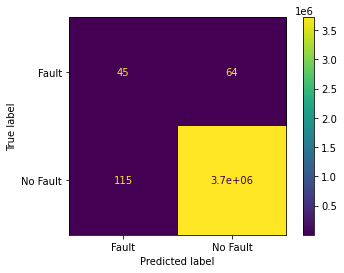

In [85]:
modelMetrics(datasetPca.fault, KNNPCAPred)

LOF con Dataset Original + PCA

In [27]:
LOFPCAPred = predicted(datasetPca.time, datasetPca.fault, LOFPCA[0][0], datasetTrain['fault_type'], 86400)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    NO         nan        nan       
9157996    NO         nan        nan       
11779286   YES        23.26      FlowCool Pressure Dropped Below Limit
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   NO         nan        nan       
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   NO         nan        nan       
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454938   NO         nan        nan       
16546

El f1-score del Modelo es: 0.99997618394391474261


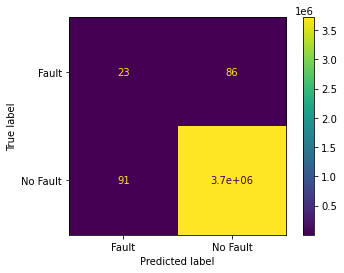

In [28]:
modelMetrics(datasetPca.fault, LOFPCAPred)

In [29]:
LOFPCAPred = predicted(datasetPca.time, datasetPca.fault, LOFPCA[0][0], datasetTrain['fault_type'], 86400*2)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    NO         nan        nan       
9157996    NO         nan        nan       
11779286   YES        23.26      FlowCool Pressure Dropped Below Limit
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   YES        24.35      FlowCool Pressure Dropped Below Limit
12869030   YES        43.32      FlowCool Pressure Dropped Below Limit
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   NO         nan        nan       
13949308   NO         nan        nan       
14652736   NO         nan        nan   

El f1-score del Modelo es: 0.99997995145021645325


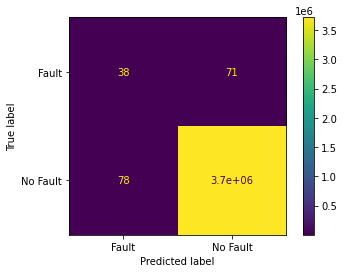

In [30]:
modelMetrics(datasetPca.fault, LOFPCAPred)

In [32]:
LOFPCAPred = predicted(datasetPca.time, datasetPca.fault, LOFPCA[0][0], datasetTrain['fault_type'], 86400*3)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    NO         nan        nan       
9157996    NO         nan        nan       
11779286   YES        23.26      FlowCool Pressure Dropped Below Limit
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   YES        24.35      FlowCool Pressure Dropped Below Limit
12869030   YES        43.32      FlowCool Pressure Dropped Below Limit
13117446   YES        53.42      Flowcool Pressure Too High Check Flowcool Pump
13120338   YES        54.22      Flowcool Pressure Too High Check Flowcool Pump
13147004   YES        61.63      Flowcool Pressure Too High Check Flowcool Pump
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   NO      

El f1-score del Modelo es: 0.99998250798375987181


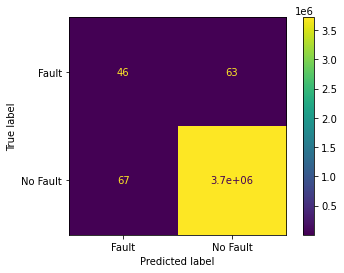

In [33]:
modelMetrics(datasetPca.fault, LOFPCAPred)

OC-SVM con Dataset Original + PCA

In [39]:
OCSVMPCAPred = predicted(datasetPca.time, datasetPca.fault, OCSVMPCA[0][0], datasetTrain['fault_type'], 86400)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    NO         nan        nan       
9157996    NO         nan        nan       
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   NO         nan        nan       
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   NO         nan        nan       
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454938   NO         nan        nan       
16546682   NO         nan       

El f1-score del Modelo es: 0.99995815313503655375


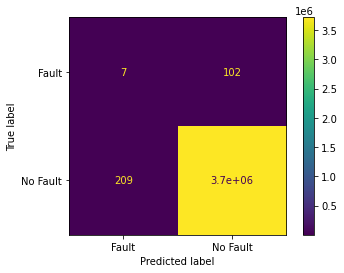

In [40]:
modelMetrics(datasetPca.fault, OCSVMPCAPred)

In [41]:
OCSVMPCAPred = predicted(datasetPca.time, datasetPca.fault, OCSVMPCA[0][0], datasetTrain['fault_type'], 86400*2)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    NO         nan        nan       
9157996    NO         nan        nan       
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   YES        46.06      FlowCool Pressure Dropped Below Limit
12869030   NO         nan        nan       
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   NO         nan        nan       
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454938   NO         nan        nan       
16546

El f1-score del Modelo es: 0.99995869134726356187


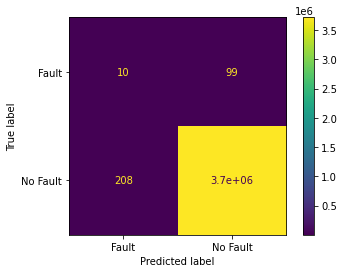

In [42]:
modelMetrics(datasetPca.fault, OCSVMPCAPred)

In [64]:
OCSVMPCAPred = predicted(datasetPca.time, datasetPca.fault, OCSVMPCA[0][0], datasetTrain['fault_type'], 86400*3)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    NO         nan        nan       
6761130    NO         nan        nan       
7858638    NO         nan        nan       
9157996    NO         nan        nan       
11779286   NO         nan        nan       
12276768   NO         nan        nan       
12631572   NO         nan        nan       
12800746   YES        46.06      FlowCool Pressure Dropped Below Limit
12869030   YES        65.03      FlowCool Pressure Dropped Below Limit
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   NO         nan        nan       
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   NO         nan        nan       
13255688   NO         nan        nan       
13275884   NO         nan        nan       
13949308   NO         nan        nan       
14652736   NO         nan        nan       
16454938   NO         

El f1-score del Modelo es: 0.99995869134726356187


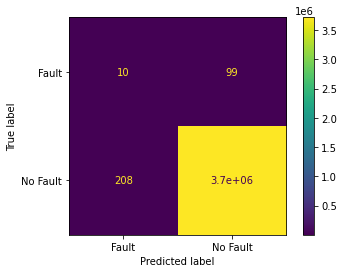

In [43]:
modelMetrics(datasetPca.fault, OCSVMPCAPred)

Autoencoder con Dataset Original + PCA

In [26]:
ATCRPCAPred = predicted(datasetPca.time, datasetPca.fault, ATCRPCA[0][0], datasetTrain['fault_type'], 86400)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    YES        7.47       FlowCool Pressure Dropped Below Limit
6761130    NO         nan        nan       
7858638    YES        0.49       FlowCool Pressure Dropped Below Limit
9157996    NO         nan        nan       
11779286   NO         nan        nan       
12276768   YES        10.7       FlowCool Pressure Dropped Below Limit
12631572   NO         nan        nan       
12800746   YES        18.56      FlowCool Pressure Dropped Below Limit
12869030   YES        14.65      FlowCool Pressure Dropped Below Limit
13117446   NO         nan        nan       
13120338   NO         nan        nan       
13147004   YES        6.68       Flowcool Pressure Too High Check Flowcool Pump
13220880   NO         nan        nan       
13224756   NO         nan        nan       
13230776   YES        0.62       Flowcool Pressure Too High Check Flowcool Pump
13255688   YES        7.54       Flowcool Pre

El f1-score del Modelo es: 0.99321190164558892377


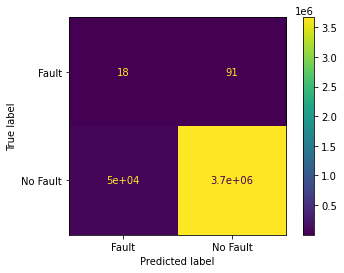

In [27]:
modelMetrics(datasetPca.fault, ATCRPCAPred)

In [28]:
ATCRPCAPred = predicted(datasetPca.time, datasetPca.fault, ATCRPCA[0][0], datasetTrain['fault_type'], 86400*2)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    YES        7.47       FlowCool Pressure Dropped Below Limit
6761130    YES        42.1       FlowCool Pressure Dropped Below Limit
7858638    YES        0.49       FlowCool Pressure Dropped Below Limit
9157996    YES        24.7       FlowCool Pressure Dropped Below Limit
11779286   YES        25.86      FlowCool Pressure Dropped Below Limit
12276768   YES        10.7       FlowCool Pressure Dropped Below Limit
12631572   NO         nan        nan       
12800746   YES        18.56      FlowCool Pressure Dropped Below Limit
12869030   YES        14.65      FlowCool Pressure Dropped Below Limit
13117446   YES        40.15      Flowcool Pressure Too High Check Flowcool Pump
13120338   YES        40.95      Flowcool Pressure Too High Check Flowcool Pump
13147004   YES        6.68       Flowcool Pressure Too High Check Flowcool Pump
13220880   YES        27.2       Flowcool Pressure Too High 

El f1-score del Modelo es: 0.99393664393945957425


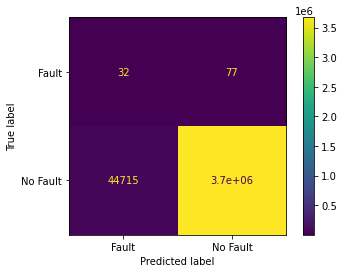

In [29]:
modelMetrics(datasetPca.fault, ATCRPCAPred)

In [30]:
ATCRPCAPred = predicted(datasetPca.time, datasetPca.fault, ATCRPCA[0][0], datasetTrain['fault_type'], 86400*3)

timestamp  Predicted  hours      Type      
5817194    NO         nan        nan       
6562858    YES        7.47       FlowCool Pressure Dropped Below Limit
6761130    YES        42.1       FlowCool Pressure Dropped Below Limit
7858638    YES        0.49       FlowCool Pressure Dropped Below Limit
9157996    YES        24.7       FlowCool Pressure Dropped Below Limit
11779286   YES        25.86      FlowCool Pressure Dropped Below Limit
12276768   YES        10.7       FlowCool Pressure Dropped Below Limit
12631572   YES        51.18      FlowCool Pressure Dropped Below Limit
12800746   YES        18.56      FlowCool Pressure Dropped Below Limit
12869030   YES        14.65      FlowCool Pressure Dropped Below Limit
13117446   YES        40.15      Flowcool Pressure Too High Check Flowcool Pump
13120338   YES        40.95      Flowcool Pressure Too High Check Flowcool Pump
13147004   YES        6.68       Flowcool Pressure Too High Check Flowcool Pump
13220880   YES        27.2       

El f1-score del Modelo es: 0.99465655566843114155


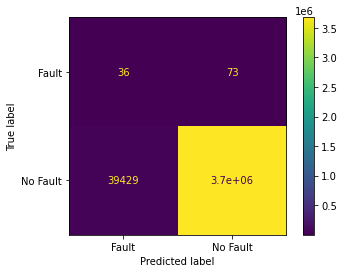

In [31]:
modelMetrics(datasetPca.fault, ATCRPCAPred)